In [2]:
from typing import Annotated, Literal, TypedDict
import tools
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
import json

def save_json(data, filepath):
    with open(filepath, 'w') as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

In [2]:
import re
from typing import Annotated, List, Optional
import operator

from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig, RunnableLambda, RunnablePassthrough, RunnableAssign
from tools import prompt_tool

class Doc(TypedDict):
    id: str
    content: str
    # summary: Optional[str]
    # explanation: Optional[str]
    # category: Optional[str]
class TaxonomyGenerationState(TypedDict):
    documents: List[Doc]

    # summaries: List[str]
    # # The raw docs; we inject summaries within them in the first step
    # # Indices to be concise
    # minibatches: List[List[int]]
    # # Candidate Taxonomies (full trajectory)
    # clusters: Annotated[List[List[dict]], operator.add]
    

# Now combine as a "map" operation in a map-reduce chain
# Input: state
# Output: state U summaries
# Processes docs in parallel
def get_input_func(state: TaxonomyGenerationState, state_input_key: str, doc_input_key: str):
    docs = state[state_input_key] # how to get the list of docs from the state (e.g. state["documents"])
    return [{doc_input_key: doc[doc_input_key]} for doc in docs] # how to get the input field from a doc (e.g. doc["content"])

def fake_llm(state):
    print(state)
    return [{"summary": "This is a summary", "explanation": "This is an explanation"} for _ in state]

def reduce_func(combined: dict, state_input_key: str, state_output_key: str):
    outputs = combined[state_output_key] # "summaries"
    documents = combined[state_input_key] # "documents"
    return {
        "documents": [
            {
                **doc,
                **{k: v for k, v in output.items()}
            }
            for doc, output in zip(documents, outputs)
        ]
    }

# map_step = RunnablePassthrough.assign(
#     # This effectively creates a "map" operation # Note you can make this more robust by handling individual errors
#     summaries=get_content | RunnableLambda(func=summary_chain.batch, afunc=summary_chain.abatch)
# )
json_schema = "{{summary: str, explanation: str}}"
summary_prompt = tools.parse_template([
    {
        "role": "system",
        "content": f"You are a summarization system. Please summarize the following text and give an explanation. Reply with the following JSON format: {json_schema}",
    },
    {
        "role": "human",
        "content": "{content}"
    }
])
summary_chain = tools.prompt_tool(
    tool_name="summarization",
    prompt_template=summary_prompt,
    model="gpt-4o-mini",
    api_key=open("../api_key").read(),
    format="json"
)

state_output_key = "summaries"
get_input = lambda x: get_input_func(x, "documents", "content")
map_step = RunnableAssign({state_output_key: get_input | RunnableLambda(func=summary_chain.batch, afunc=summary_chain.abatch)})
reduce_step = lambda x: reduce_func(x, "documents", state_output_key)
# This is actually the node itself!
map_reduce_chain = map_step | reduce_step

In [ ]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(TaxonomyGenerationState)
graph.add_node("summarize", map_reduce_chain)
graph.add_edge(START, "summarize")

app = graph.compile()

import json
docs = json.load(open("docs.json"))
final_state = app.invoke(
    {"documents": docs},
    config={"configurable": {"thread_id": 42}},
)
from pprint import pprint
pprint(final_state)


In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
from pprint import pprint
pprint(final_state)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
json_schema = "{{summary: str, explanation: str}}"
messages = [
    {
        "role": "system",
        "content": f"You are a summarization system. Please summarize the following text and give an explanation. Reply with the following JSON format: {json_schema}",
    },
    {
        "role": "human",
        "content": "{content}"
    }
]
summary_prompt = tools.parse_template(messages)
print(summary_prompt)
template = ChatPromptTemplate(summary_prompt)
template

In [11]:
api_key = open("api_key").read()
test_steps = [
    {
        "id": "0",
        "label": "Entity Extraction",
        "state_input_key": "documents",
        "doc_input_keys": ["content"],
        "state_output_key": "entities",
        "parentIds": [],
        "execution": {
            "tool": "prompt_tool",
            "parameters": {
                "name": "entity_extraction",
                "model": "gpt-4o-mini",
                "api_key": api_key,
                "format": "json",
                "prompt_template": [
                    {
                        "role": "system",
                        "content": """
                            ** Context **
                            You are an entity extraction system. The user will give you a piece of text.
                            ** Task **
                            Your task is to extract the entities from the text. 
                            ** Requirements **
                            Reply with the following JSON format: {{ "entities": ["entity1", "entity2", ...] }}
                        """,
                    },
                    {
                        "role": "human",
                        "content": "{content}"
                    }
                ],
            }
        }
    },
    {
        "id": "1",
        "label": "Relationship Extraction",
        "state_input_key": "documents",
        "doc_input_keys": ["content", "entities"],
        "state_output_key": "relationships",
        "parentIds": ["0"],
        "execution": {
            "tool": "prompt_tool",
            "parameters": {
                "name": "relationship_extraction",
                "model": "gpt-4o-mini",
                "api_key": api_key,
                "format": "json",
                "prompt_template": [
                    {
                        "role": "system",
                        "content": """
                        ** Context **
                        You are a relationship extraction system. The user will give you a piece of text and the entities extracted from it.
                        ** Task **
                        Your task is to extract the relationships between entities from the text. 
                        ** Requirements **
                        Reply with the following JSON format: 
                            {{ "relationships": [
                                {{
                                    "label": (str, label for the relationship), 
                                    "source": (str, entity1),
                                    "target": (str, entity2),
                                    "explanation": (str, explanation of the relationship)
                                }}, 
                                {{
                                    "label": (str, label for the relationship), 
                                    "source": (str, entity1),
                                    "target": (str, entity2),
                                    "explanation": (str, explanation of the relationship)
                                }}, 
                                ...
                                ] 
                            }}
                        """
                    },
                    {
                        "role": "human",
                        "content": "Content: {content}\n Entities: {entities}"
                    }
                ]
            }
        }
    }
]
from langgraph_utils import create_graph
graph = create_graph(test_steps)

In [14]:
thread_config = {"configurable": {"thread_id": 42}}
node_id = "0"
node_configs = list(
    reversed(
        [
            step
            for step in graph.get_state_history(thread_config)
            if step.next == f"{node_id}_evaluation"
        ]
    )
)

In [16]:
node_configs[-1]

IndexError: list index out of range

In [10]:
from pprint import pprint
for node in graph.get_graph().nodes:
    if node == "__start__": continue
    print(node)

0
0_evaluation
1
1_evaluation


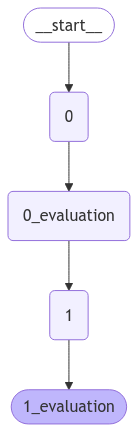

In [2]:
from IPython.display import Image, display
app = graph.compile()
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import json
from langgraph.checkpoint.memory import MemorySaver

# app = graph.compile(interrupt_after=list(map(lambda step: step['id'], test_steps)), checkpointer=MemorySaver())
# app = graph.compile(checkpointer=MemorySaver())
docs = json.load(open("docs.json"))
thread_config = {"configurable": {"thread_id": 42}}
state = {"documents": docs}
state = app.invoke(
    state,
    config=thread_config,
)
from pprint import pprint
pprint(state['documents'][0].keys())
# pprint(state)
# initial_input = {"documents": docs}
# thread = {"configurable": {"thread_id": 42}}
# for event in app.stream(initial_input, thread, stream_mode="updates"):
#     print(event)
#     print("\n")

dict_keys(['id', 'content', 'entities'])


In [18]:
app.get_state(config=thread_config).tasks

(PregelTask(id='38cbb075-d527-8ab6-cb10-3a854c383f10', name='0_evaluation', path=('__pregel_pull', '0_evaluation'), error=None, interrupts=(), state=None, result=None),)

In [12]:
for intermediate_state in app.get_state_history(thread_config):
    print(intermediate_state.values)
    print(intermediate_state.next)
# last_state_config = list(app.get_state_history(thread_config))[-2].config


NameError: name 'app' is not defined

In [ ]:
state = app.invoke(None, config=last_state_config)
from pprint import pprint
pprint(state['documents'][0].keys())

dict_keys(['id', 'content', 'entities'])
{'documents': [{'content': 'Budget to set scene for election\n'
                           ' \n'
                           ' Gordon Brown will seek to put the economy at the '
                           "centre of Labour's bid for a third term in power "
                           'when he delivers his ninth Budget at 1230 GMT. He '
                           'is expected to stress the importance of continued '
                           'economic stability, with low unemployment and '
                           'interest rates. The chancellor is expected to '
                           'freeze petrol duty and raise the stamp duty '
                           'threshold from Â£60,000. But the Conservatives and '
                           'Lib Dems insist voters face higher taxes and more '
                           'means-testing under Labour.\n'
                           ' \n'
                           ' Treasury officials have said there 

In [25]:
from langgraph.types import Command, interrupt
state = app.invoke(
    Command(resume=True),
    config={"configurable": {"thread_id": 42}},
)
from pprint import pprint
pprint(state['documents'][0].keys())
# for event in app.stream(
#     Command(resume="go to step 3!"), thread, stream_mode="updates"
# ):
#     print(event)
#     print("\n")

dict_keys(['id', 'content', 'entities', 'relationships'])


In [7]:
from langgraph.types import Command, interrupt
state = app.invoke(
    Command(resume={"approved": False}),
    config={"configurable": {"thread_id": 42}},
)
from pprint import pprint
pprint(state['documents'][0].keys())
pprint(state)
# for event in app.stream(
#     Command(resume="go to step 3!"), thread, stream_mode="updates"
# ):
#     print(event)
#     print("\n")

---human_feedback--- dict_keys(['id', 'content', 'entities', 'relationships'])
approved: False
children_id: ['1']
parent_id: 0
going to parent
---human_feedback--- dict_keys(['id', 'content', 'entities', 'relationships'])
approved: False
children_id: []
parent_id: 1
going to parent
dict_keys(['id', 'content', 'entities', 'relationships'])
{'documents': [{'content': 'Budget to set scene for election\n'
                           ' \n'
                           ' Gordon Brown will seek to put the economy at the '
                           "centre of Labour's bid for a third term in power "
                           'when he delivers his ninth Budget at 1230 GMT. He '
                           'is expected to stress the importance of continued '
                           'economic stability, with low unemployment and '
                           'interest rates. The chancellor is expected to '
                           'freeze petrol duty and raise the stamp duty '
                 

dict_keys(['id', 'content', 'entities'])
